In [1]:
import sys
import os

# Add the parent directory to the sys.path
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from scipy.interpolate import griddata, interp2d
from matplotlib.animation import FuncAnimation, PillowWriter

from nv_files.Field_Generator import omega0_samples,omega0_samples_torch
from nv_files.FEM_Solver import VorticitySolver
from nv_files.Pseudo_Spectral_Solver import VorticitySolver2D
from Base.utilities import clear_hooks
from Base.lla import dgala

import torch
from ml_collections import ConfigDict
from scipy.interpolate import griddata

from nv_files.utilities import deepgala_data_fit,generate_noisy_obs
from nv_files.NavierStokes import NavierStokes
from nv_files.Pseudo_Spectral_Solver import VorticitySolver2D

# CUDA for PyTorch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [22]:
import sys
import os
import argparse
import numpy as np

# project_root = os.path.abspath(os.path.join(os.path.dirname(__file__), "../.."))
# sys.path.append(project_root)  # This allows importing from base, Elliptic, etc.
# sys.path.append(os.path.join(project_root, "navier_stokes"))  # Explicitly add Elliptic folder

from copy import deepcopy
from math import sqrt, pi
from Base.utilities import FeatureExtractor,get_decorated_methods

from torch.nn.utils import parameters_to_vector

class dgala(torch.nn.Module):
    def __init__(self, dga, sigma_noise=1., prior_precision=1.,prior_mean=0., last_layer_name = "output_layer"):
        super(dgala, self).__init__()

        self.dgala = deepcopy(dga)
        self.model = FeatureExtractor(deepcopy(dga.model), last_layer_name = last_layer_name)
        self._device = next(dga.model.parameters()).device
        self.lossfunc = torch.nn.MSELoss(reduction ='mean')
        
        self.loss = 0
        self.temperature = 1
        self.H = None
        self.mean = None
        self.n_params = None
        self.n_data = {key: None for key in self.dgala.lambdas.keys()}

        self._prior_precision = torch.tensor([prior_precision], device=self._device)
        self._prior_mean = torch.tensor([prior_mean], device=self._device)
        self._sigma_noise = torch.tensor(sigma_noise,device=self._device).float()

        if hasattr(self.dgala, "chunks"):
            self.chunks = self.dgala.chunks
            self.gamma = self.dgala.gamma.clone()
        else:
            self.chunks = None

    @property
    def prior_precision(self):
        return self._prior_precision
    
    @prior_precision.setter
    def prior_precision(self, new_prior_precision):
        if isinstance(new_prior_precision, torch.Tensor):
            self._prior_precision = new_prior_precision.to(self._device)
        else:
            self._prior_precision = torch.tensor([new_prior_precision], device=self._device).float()

    @property
    def sigma_noise(self):
        return self._sigma_noise

    @sigma_noise.setter
    def sigma_noise(self, new_sigma_noise):
        if isinstance(new_sigma_noise, torch.Tensor):
            self._sigma_noise = new_sigma_noise.to(self._device)
        else:
            self._sigma_noise = torch.tensor(new_sigma_noise, device=self._device,requires_grad=True).float()

    @property
    def posterior_precision(self):
        """Diagonal posterior precision \\(p\\)."""
        return self._H_factor * self.H + torch.diag(self.prior_precision_diag)

    @property
    def posterior_covariance(self):
        """Diagonal posterior variance \\(p^{-1}\\).""" 
        post_scale = _precision_to_scale_tril(self.posterior_precision)
        return post_scale @ post_scale.T

    @property
    def _H_factor(self):
        sigma2 = self.sigma_noise.square()
        return 1 / (2*sigma2) / self.temperature
    
    @property
    def prior_precision_diag(self):
        """Obtain the diagonal prior precision \\(p_0\\) constructed from either
        a scalar, layer-wise, or diagonal prior precision."""

        if len(self.prior_precision) == 1:  # scalar
            return self.prior_precision * torch.ones(self.n_params, device=self._device)

        elif len(self.prior_precision) == self.n_params:  # diagonal
            return self.prior_precision
        
    @property
    def scatter(self):
        """Computes the _scatter_, a term of the log marginal likelihood that
        corresponds to L-2 regularization:
        `scatter` = \\((\\theta_{MAP} - \\mu_0)^{T} P_0 (\\theta_{MAP} - \\mu_0) \\)."""

        delta = (self.mean - self.prior_mean)
        return (delta * self.prior_precision_diag) @ delta

    @property
    def log_det_prior_precision(self):
        """Compute log determinant of the prior precision
        \\(\\log \\det P_0\\)"""

        return self.prior_precision_diag.log().sum()

    @property
    def log_det_posterior_precision(self):
        """Compute log determinant of the posterior precision
        \\(\\log \\det P\\) which depends on the subclasses structure
        used for the Hessian approximation."""
        return self.posterior_precision.logdet()

    @property
    def log_det_ratio(self):
        """Compute the log determinant ratio, a part of the log marginal likelihood.
        \\[
            \\log \\frac{\\det P}{\\det P_0} = \\log \\det P - \\log \\det P_0
        \\]log"""
        return self.log_det_posterior_precision - self.log_det_prior_precision
    
    @property
    def log_likelihood(self):
        """Compute log likelihood on the training data after `.fit()` has been called.
        The log likelihood is computed on-demand based on the loss and, for example,
        the observation noise, which makes it differentiable in the latter for
        iterative updates."""

        factor = -self._H_factor
        total_log_likelihood = 0.0

        for key, loss_value in self.loss.items():
            # Compute the normalizer term for Gaussian likelihood
            n_data_key = self.n_data[key]  # Number of data points for this key
            normalizer = n_data_key * torch.log(self.sigma_noise*sqrt(2*pi))
            weight = self.dgala.lambdas[key]

            # Compute log likelihood contribution for this key
            log_likelihood_key = factor *n_data_key* loss_value*weight - normalizer

            # Accumulate total log likelihood
            total_log_likelihood += log_likelihood_key

        return total_log_likelihood
    

    def fit(self,fit_data):
        """Fit the local Laplace approximation at the parameters of the model."""
        
        self.class_methods = get_decorated_methods(self.dgala, decorator = "use_laplace")

       # assert set(self.class_methods) == set([element for sublist in fit_data["class_method"].values() for element in sublist])

        self.dgala.model.eval()
        #self.mean = parameters_to_vector(self.dgala.model.output_layer.parameters()).detach()
        self.mean = parameters_to_vector(self.model.last_layer.parameters()).detach()
        self.n_params = len(self.mean)
        self.prior_mean = self._prior_mean
        self._init_H()

        # Dynamically pass the `data_fit` contents as *args
        data_fit_args = fit_data.get("data_fit", {})
        unpacked_args = []
        for key, value in data_fit_args.items():
            if isinstance(value, tuple):
                # Unpack the tuple and add its elements individually
                unpacked_args.extend(value)
            else:
                # Add non-tuple values directly
                unpacked_args.append(value)

        loss = self.dgala.losses(*unpacked_args,loss_fn = self.lossfunc)

        self.loss = {key:loss.item() for key,loss in loss.items()}

        self.full_Hessian(fit_data)
        
    def _init_H(self):
        self.H = torch.zeros(self.n_params,self.n_params,device=self._device)

    def gradient_outograd(self, y, x):
        grad_p = torch.autograd.grad(outputs=y, 
                                 inputs=x, create_graph=True, allow_unused=True, materialize_grads=True)
        return [grp.detach() for grp in grad_p]
    
    def full_Hessian(self,fit_data):
        parameters_ = list(self.dgala.model.output_layer.parameters())
        h = torch.zeros(self.n_params,self.n_params,device = self._device)
        damping = torch.eye(self.n_params,device=self._device)

        for key,dt_fit in fit_data["data_fit"].items():
            dt_fit = dt_fit[1] if isinstance(dt_fit, tuple) else dt_fit

            for z,clm in enumerate(fit_data["class_method"][key]):
                self.dgala.model.zero_grad()
                fout = getattr(self.dgala, clm)(dt_fit)
                #damping_factor = 1e-5 if key =="pde" else 1

                if isinstance(fout, tuple):  # Check if fout is a tuple
                    for i, f_out_indv in enumerate(fout):  # Iterate over fout if it's a tuple
                        indv_h = self.compute_hessian(f_out_indv,parameters_,key)
                        h+= indv_h*self.dgala.lambdas[fit_data["outputs"][key][i]]
                        self.n_data[fit_data["outputs"][key][i]] = f_out_indv.shape[0]
                else:
                    indv_h = self.compute_hessian(fout,parameters_,key)
                    h += indv_h*self.dgala.lambdas[fit_data["outputs"][key][z]]
                    self.n_data[fit_data["outputs"][key][z]] = fout.shape[0]
                
        # eigvals, eigvecs = torch.linalg.eigh(h)
        # #eigvals_clamped = torch.clamp(eigvals, min=0.0)
        # #hessian_psd = eigvecs @ torch.diag(eigvals_clamped) @ eigvecs.T
        # #hessian_psd = 0.5 * (hessian_psd + hessian_psd.T)

        # negative_eigvals = eigvals[eigvals < 0]

        # if len(negative_eigvals) > 0:
        #     largest_negative = -negative_eigvals.min()
        # else:
        #     largest_negative = 0  # or handle case with no negative eigenvalues

        # # hessian_loss += (largest_negative + 1e-10)*damping
        # # choose eps relative to largest eigenvalue
        # α = 1e-7  # float32
        # eps = α * eigvals.abs().max()

        # print(f"Largest negative eigenvalue {largest_negative}")
        # self.H = h + (largest_negative + eps)*damping
        self.H = h


                
    def compute_hessian (self,output,parameters_,key):
        hessian_loss = torch.zeros(self.n_params,self.n_params,device = self._device)
        damping = torch.eye(self.n_params,device=self._device)
        neg_eigvals = []
        if self.chunks: 
            nitems_chunk = output.shape[0] // self.chunks
            chunk_counter = 0

        for i,fo in enumerate(output):
            grad_p = self.gradient_outograd(fo,parameters_)
            
            ndim = grad_p[0].shape[0]

            reshaping_grads = [g.reshape(ndim,-1) for g in grad_p]
            # Concatenate along the parameter axis
            jacobian_matrix = torch.cat(reshaping_grads, dim=1).reshape(1,-1)
            h_indv = jacobian_matrix.T @ jacobian_matrix
            hessian_loss +=  h_indv 
            if self.chunks and (i + 1) % nitems_chunk == 0 and key == "pde":

                hessian_loss *= self.gamma[chunk_counter]
                chunk_counter += 1

        # Compute eigen-decomposition
        eigvals, eigvecs = torch.linalg.eigh(hessian_loss)

        # # Clamp negative eigenvalues to zero
        eigvals_clamped = torch.clamp(eigvals, min=0.0)

        # # Reconstruct the PSD Hessian
        hessian_psd = eigvecs @ torch.diag(eigvals_clamped) @ eigvecs.T

        # # Optional: ensure symmetry (numerical stability)
        # hessian_psd = 0.5 * (hessian_psd + hessian_psd.T)

        negative_eigvals = eigvals[eigvals < 0]

        if len(negative_eigvals) > 0:
            largest_negative = -negative_eigvals.min()
        else:
            largest_negative = 0  # or handle case with no negative eigenvalues

        # # hessian_loss += (largest_negative + 1e-10)*damping

        print(f"Largest negative eigenvalue {largest_negative}")
        return hessian_loss


In [23]:


def nv_experiment():
    config = ConfigDict()
    config.verbose = False

    # Train config
    config.train = False

    # Weights & Biases
    config.wandb = wandb = ConfigDict()
    wandb.project = "Experiment_NV"
    wandb.name = "Vorticity"
    wandb.tag = None

    # General settings
    config.nn_model = "MDNN"  # Options: "NN", "WRF", "MDNN"
    config.lambdas = {"nvs":1, "cond":1, "w0":1, "phi":1}

    # Model-specific settings
    config.model = ConfigDict()
    config.model.input_dim = 3 + 2
    config.model.hidden_dim = 300
    config.model.num_layers = 3 
    config.model.out_dim = 2
    config.model.activation = "tanh"

    # Weight-Random-Factorization
    #config.reparam = ConfigDict({"type":"weight_fact","mean":1.0,"stddev":0.1})

     # Periodic embeddings
    config.model.period_emb = ConfigDict({"period":(1.0, 1.0), "axis":(0, 1) })

    # Fourier embeddings
    config.model.fourier_emb = ConfigDict({"embed_scale":1,"embed_dim":300,"exclude_last_n":2})

    # Navier Stokes Config
    config.nu = 1e-2
    config.time_domain = 2

    # Training settings
    config.seed = 108
    config.learning_rate = 0.001
    config.decay_rate = 0.9
    config.alpha = 0.9  # For updating loss weights
    config.iterations = 5000
    config.start_scheduler = 0.1
    config.weights_update = 250
    config.scheduler_step = 1000 #2000

    config.chunks = 16
    config.points_per_chunk = 20
    config.batch_size = 16*10
    #config.batch_ic = 16*

    # For deep Galerkin- initial conditions
    config.d = 5
    config.tau = np.sqrt(2)
    config.KL_expansion =  1
    config.dim_initial_condition = 128
    config.samples_size_initial = 1000

    # DeepGala
    config.deepgala = False

    return config

config_experiment = nv_experiment()

nn_path_model = "./models/dgala_nv_mean_hl3_hd300_s20_b160_kl1.pth"
nn_surrogate_model = torch.load(nn_path_model, map_location=device)
nn_surrogate_model.eval()
#nn_surrogate_model.to(device)
# nn_surrogate_model.M = nn_surrogate_model.M.to(device)

Vorticity(
  (model): MDNN(
    (activation_fn): Tanh()
    (period_layer): PeriodEmbs()
    (fourier_layer): FourierEmbs()
    (u_layer): Linear(in_features=202, out_features=300, bias=True)
    (v_layer): Linear(in_features=202, out_features=300, bias=True)
    (hidden_layers): ModuleList(
      (0): Linear(in_features=202, out_features=300, bias=True)
      (1-2): 2 x Linear(in_features=300, out_features=300, bias=True)
    )
    (output_layer): Linear(in_features=300, out_features=2, bias=True)
  )
)

In [24]:
data_fit = deepgala_data_fit(config_experiment, device)

llp = dgala(nn_surrogate_model)
llp.fit(data_fit)
#llp.optimize_marginal_likelihoodb(error_tolerance=1e-4, max_iter=5000)
#clear_hooks(llp)

#torch.save(llp, dgala_path_model)

Largest negative eigenvalue 0.0002053148637060076
Largest negative eigenvalue 0.0011802277294918895
Largest negative eigenvalue 0


In [25]:
llp.H

tensor([[ 144.5859,   27.1304,   23.9004,  ...,   -9.7562,   60.7015,
            0.0000],
        [  27.1304,  300.9394,    4.0195,  ...,   97.6708,   44.8530,
            0.0000],
        [  23.9004,    4.0195,  136.6472,  ...,    9.2863,   17.4976,
            0.0000],
        ...,
        [  -9.7562,   97.6708,    9.2863,  ..., 1072.2933,  303.5374,
            0.0000],
        [  60.7015,   44.8530,   17.4976,  ...,  303.5374, 1238.2964,
            0.0000],
        [   0.0000,    0.0000,    0.0000,  ...,    0.0000,    0.0000,
            0.0000]])

In [7]:
torch.linalg.eigh(llp.H)

torch.return_types.linalg_eigh(
eigenvalues=tensor([5.6162e+00, 1.3512e+01, 3.0265e+01, 3.0790e+01, 3.1639e+01, 3.2777e+01,
        3.2850e+01, 3.4269e+01, 3.4989e+01, 3.8026e+01, 3.8876e+01, 3.9522e+01,
        3.9544e+01, 4.0190e+01, 4.1574e+01, 4.1732e+01, 4.2084e+01, 4.2573e+01,
        4.2653e+01, 4.3351e+01, 4.3699e+01, 4.3825e+01, 4.3966e+01, 4.4122e+01,
        4.4300e+01, 4.4408e+01, 4.4551e+01, 4.4621e+01, 4.4739e+01, 4.4889e+01,
        4.4980e+01, 4.4982e+01, 4.4996e+01, 4.5003e+01, 4.5034e+01, 4.5051e+01,
        4.5114e+01, 4.5117e+01, 4.5128e+01, 4.5135e+01, 4.5154e+01, 4.5155e+01,
        4.5186e+01, 4.5205e+01, 4.5212e+01, 4.5220e+01, 4.5236e+01, 4.5271e+01,
        4.5271e+01, 4.5273e+01, 4.5276e+01, 4.5277e+01, 4.5306e+01, 4.5315e+01,
        4.5323e+01, 4.5328e+01, 4.5337e+01, 4.5342e+01, 4.5346e+01, 4.5350e+01,
        4.5374e+01, 4.5383e+01, 4.5383e+01, 4.5390e+01, 4.5393e+01, 4.5399e+01,
        4.5407e+01, 4.5418e+01, 4.5422e+01, 4.5423e+01, 4.5427e+01, 4.5434e+

In [ ]:
from nv_files.nv_mcmc import NVMCMC, NVMCMCDA

obs_points, sol_test, obs_indices,_ = generate_noisy_obs(obs=config_experiment.num_observations,
                                              noise_level=config_experiment.noise_level,
                                              NKL = config_experiment.KL_expansion)
print(config_experiment.noise_level)


def run_mcmc_chain(surrogate_model, obs_points, sol_test, config_experiment,device):
    mcmc = NVMCMC(
        surrogate=surrogate_model,
        observation_locations=obs_points,
        observations_values=sol_test,
        observation_noise=np.sqrt(config_experiment.noise_level),
        nparameters=2*config_experiment.KL_expansion,
        nsamples=config_experiment.samples,
        proposal_type=config_experiment.proposal,
        step_size=config_experiment.proposal_variance,
        uniform_limit = config_experiment.uniform_limit,
        device=device
    )
    return mcmc.run_chain(verbose=True)

0.001


In [37]:
dgala_path_model = "./models/dgala_nv_marginal_hl3_hd300_s20_b160_kl1.pth"

llp = torch.load(dgala_path_model, map_location=device)
llp.model.set_last_layer("output_layer")  # Re-register hooks
llp._device = device


# #nn_samples = run_mcmc_chain(llp, obs_points, sol_test, config_experiment, device)
# X = torch.linspace(0, 1, 128)*2*torch.pi  # Spatial grid in X direction
# Y = torch.linspace(0, 1, 128)*2*torch.pi  # Spatial grid in Y direction
# X, Y = torch.meshgrid(X, Y)  # Create meshgrid for X, Y

# data_test = torch.hstack((X.reshape(-1,1),Y.reshape(-1,1),2*torch.ones_like(X.reshape(-1,1)))).float()

# #th1 = theta[:,:,100].reshape(-1,1).T.repeat_interleave(data_test.shape[0], dim=0)
# th1 = torch.tensor((-1000,1000)).reshape(-1,1).T.repeat_interleave(data_test.shape[0], dim=0)
# #llp.sigma_noise = 0.021
# dataset1 = torch.cat((data_test, th1), dim=1)  # Shape (16000, 103)


In [38]:
torch.linalg.eigh(llp.H)

torch.return_types.linalg_eigh(
eigenvalues=tensor([-3.7063e+00,  2.5485e+01,  6.3162e+01,  7.3472e+01,  7.7320e+01,
         7.8420e+01,  8.0474e+01,  8.1445e+01,  8.3900e+01,  8.4185e+01,
         8.5263e+01,  8.6379e+01,  8.6801e+01,  8.8822e+01,  8.9097e+01,
         8.9449e+01,  9.0073e+01,  9.0985e+01,  9.1102e+01,  9.1281e+01,
         9.1411e+01,  9.1699e+01,  9.1740e+01,  9.1786e+01,  9.1974e+01,
         9.2140e+01,  9.2186e+01,  9.2269e+01,  9.2283e+01,  9.2364e+01,
         9.2415e+01,  9.2435e+01,  9.2470e+01,  9.2525e+01,  9.2553e+01,
         9.2565e+01,  9.2565e+01,  9.2591e+01,  9.2619e+01,  9.2625e+01,
         9.2629e+01,  9.2640e+01,  9.2670e+01,  9.2681e+01,  9.2683e+01,
         9.2695e+01,  9.2702e+01,  9.2729e+01,  9.2740e+01,  9.2745e+01,
         9.2749e+01,  9.2756e+01,  9.2780e+01,  9.2782e+01,  9.2788e+01,
         9.2797e+01,  9.2797e+01,  9.2816e+01,  9.2817e+01,  9.2820e+01,
         9.2833e+01,  9.2838e+01,  9.2838e+01,  9.2842e+01,  9.2850e+01,
       

In [76]:
Js, f_mu  = llp.last_layer_jacobians(dataset1)

In [80]:
Js[0,1,:]

tensor([ 0.0000e+00, -0.0000e+00,  0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00,  0.0000e+00, -0.0000e+00,  0.0000e+00,
        -0.0000e+00, -0.0000e+00,  0.0000e+00,  0.0000e+00, -0.0000e+00,
        -0.0000e+00,  0.0000e+00,  0.0000e+00, -0.0000e+00, -0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         0.0000e+00, -0.0000e+00, -0.0000e+00,  0.0000e+00,  0.0000e+00,
        -0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
        -0.0000e+00, -0.0000e+00,  0.0000e+00, -0.0000e+00, -0.0000e+00,
        -0.0000e+00,  0.0000e+00,  0.0000e+00, -0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         0.0000e+00,  0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0000e+00,
         0.0000e+00,  0.0000e+00, -0.0000e+00, -0.0000e+00,  0.0000e+00,
        -0.0000e+00, -0.0000e+00, -0.0000e+00, -0.0

In [54]:
f_var = llp.functional_variance(Js)
torch.diagonal(f_var, dim1 = 1, dim2 = 2)

tensor([[0.1757, 0.0759],
        [0.1758, 0.0760],
        [0.1758, 0.0760],
        ...,
        [0.1756, 0.0759],
        [0.1757, 0.0759],
        [0.1757, 0.0759]])

In [74]:
Js[:,0,:]

IndexError: too many indices for tensor of dimension 2

In [64]:
full_cov = torch.einsum("bdi,ij,cdj->bcd", Js,llp.posterior_covariance, Js)


In [56]:
full_cov[:,:,0]

tensor([[0.1757, 0.1758, 0.1758,  ..., 0.1757, 0.1757, 0.1757],
        [0.1758, 0.1758, 0.1758,  ..., 0.1757, 0.1757, 0.1758],
        [0.1758, 0.1758, 0.1758,  ..., 0.1757, 0.1758, 0.1758],
        ...,
        [0.1757, 0.1757, 0.1757,  ..., 0.1756, 0.1757, 0.1757],
        [0.1757, 0.1757, 0.1758,  ..., 0.1757, 0.1757, 0.1757],
        [0.1757, 0.1758, 0.1758,  ..., 0.1757, 0.1757, 0.1757]])

In [57]:
torch.diag(full_cov[:,:,0]).shape

torch.Size([16384])

In [66]:
f_mu

tensor([[0.1757, 0.0759],
        [0.1758, 0.0760],
        [0.1758, 0.0760],
        ...,
        [0.1756, 0.0759],
        [0.1757, 0.0759],
        [0.1757, 0.0759]])

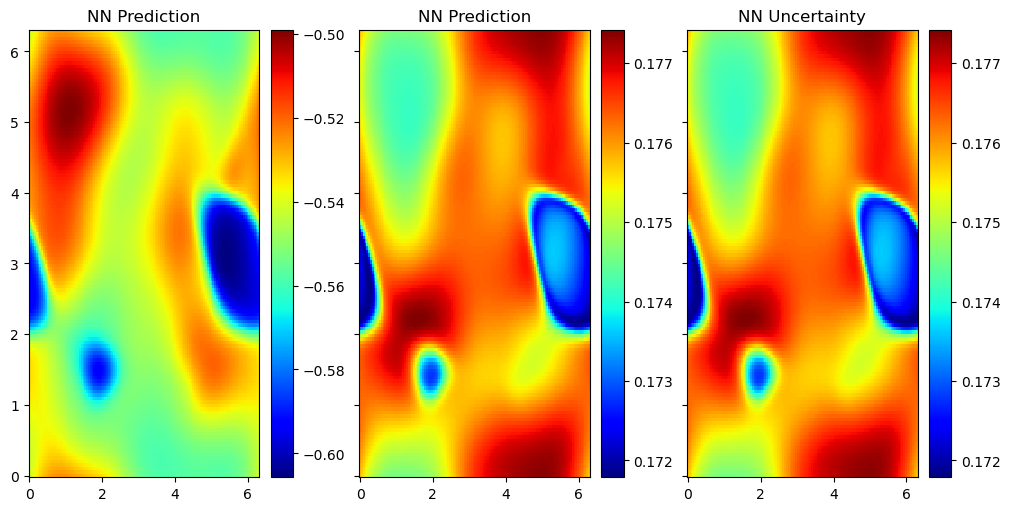

In [71]:
fig, axs = plt.subplots(1,3,figsize = (10,5), layout='constrained', sharey=True, sharex=True)

Js, f_mu  = llp(dataset1)
pred_mu = griddata((X.reshape(-1), Y.reshape(-1)), Js[:,0].flatten(),(X, Y), method='cubic')

pcm1 = axs[0].pcolormesh(X, Y, pred_mu, cmap='jet')
axs[0].set_title("NN Prediction")
plt.colorbar(pcm1)

pred_mu = griddata((X.reshape(-1), Y.reshape(-1)), f_mu[:,0].flatten(),(X, Y), method='cubic')

pcm1 = axs[1].pcolormesh(X, Y, pred_mu, cmap='jet')
axs[1].set_title("NN Prediction")
plt.colorbar(pcm1)


pred_sigma = griddata((X.reshape(-1), Y.reshape(-1)), torch.diag(full_cov[:,:,0]).flatten(),(X, Y), method='cubic')

pcm = axs[2].pcolormesh(X, Y,pred_sigma , cmap='jet')
axs[2].set_title("NN Uncertainty")
plt.colorbar(pcm)

In [27]:
torch.diagonal(full_cov, dim1 = 1, dim2 = 2)

tensor([[0.1757, 0.0760],
        [0.1758, 0.0760],
        [0.1758, 0.0760],
        ...,
        [0.1757, 0.0759],
        [0.1757, 0.0759],
        [0.1757, 0.0760]])

In [26]:
llp.gamma

tensor([1.0000, 1.0000, 0.9999, 0.9998, 0.9998, 0.9997, 0.9997, 0.9996, 0.9996,
        0.9995, 0.9994, 0.9994, 0.9992, 0.9989, 0.9987, 0.9986])

In [23]:
torch.linalg.eigvals(llp.posterior_precision)

tensor([6.0469e+08+0.j, 3.7801e+08+0.j, 1.6417e+08+0.j, 1.0152e+08+0.j, 6.4850e+07+0.j,
        6.2261e+07+0.j, 5.8440e+07+0.j, 5.6165e+07+0.j, 3.5820e+07+0.j, 3.1136e+07+0.j,
        2.6483e+07+0.j, 2.3675e+07+0.j, 2.2014e+07+0.j, 2.1227e+07+0.j, 1.9264e+07+0.j,
        1.7987e+07+0.j, 1.7562e+07+0.j, 1.5433e+07+0.j, 1.3556e+07+0.j, 1.2914e+07+0.j,
        1.1734e+07+0.j, 1.1271e+07+0.j, 1.0643e+07+0.j, 1.0496e+07+0.j, 9.3945e+06+0.j,
        8.3740e+06+0.j, 7.9565e+06+0.j, 7.5791e+06+0.j, 7.0509e+06+0.j, 6.7732e+06+0.j,
        6.4409e+06+0.j, 6.3021e+06+0.j, 6.1582e+06+0.j, 6.0219e+06+0.j, 5.7392e+06+0.j,
        5.6503e+06+0.j, 5.5102e+06+0.j, 5.4090e+06+0.j, 5.0784e+06+0.j, 4.8279e+06+0.j,
        4.6955e+06+0.j, 4.5318e+06+0.j, 4.2590e+06+0.j, 4.2180e+06+0.j, 4.0777e+06+0.j,
        3.9586e+06+0.j, 3.8640e+06+0.j, 3.7772e+06+0.j, 3.6548e+06+0.j, 3.5992e+06+0.j,
        3.4398e+06+0.j, 3.3521e+06+0.j, 3.3137e+06+0.j, 3.1883e+06+0.j, 3.0837e+06+0.j,
        3.0456e+06+0.j, 3.0017e+

In [30]:
from Base.utilities import clear_hooks

clear_hooks(llp)
torch.save(llp, f"./models/nvs_lla2.pth")

In [10]:
eingen = torch.real(torch.linalg.eig(llp.H)[0])
eingen[eingen<0]

tensor([])

In [11]:
eingen

tensor([1.4905e+05, 8.2858e+04, 6.5130e+04, 6.0340e+04, 5.5484e+04, 5.1745e+04,
        4.8991e+04, 4.5703e+04, 4.4849e+04, 4.0639e+04, 4.0339e+04, 3.6916e+04,
        3.5955e+04, 3.4974e+04, 3.3474e+04, 3.1470e+04, 3.0908e+04, 3.0265e+04,
        2.9257e+04, 2.8371e+04, 2.7358e+04, 2.6528e+04, 2.5497e+04, 2.4854e+04,
        2.3260e+04, 2.2991e+04, 2.2019e+04, 2.1225e+04, 2.0670e+04, 1.9320e+04,
        1.9273e+04, 1.8255e+04, 1.7719e+04, 1.7019e+04, 1.6283e+04, 1.5508e+04,
        1.4701e+04, 1.4460e+04, 1.4085e+04, 1.3717e+04, 1.3226e+04, 1.3123e+04,
        1.2337e+04, 1.2242e+04, 1.1900e+04, 1.1518e+04, 1.1026e+04, 1.0835e+04,
        1.0532e+04, 1.0276e+04, 9.8826e+03, 9.6609e+03, 9.7300e+03, 9.0955e+03,
        8.9225e+03, 8.6840e+03, 8.3849e+03, 8.3224e+03, 8.1107e+03, 7.9013e+03,
        7.7286e+03, 7.5460e+03, 7.3816e+03, 7.2213e+03, 6.9742e+03, 6.9114e+03,
        6.6801e+03, 6.6193e+03, 6.5485e+03, 6.4097e+03, 6.3517e+03, 6.0837e+03,
        5.9067e+03, 5.7943e+03, 5.7088e+

Text(0.5, 1.0, 'Marg.Lik: Prior Prec.')

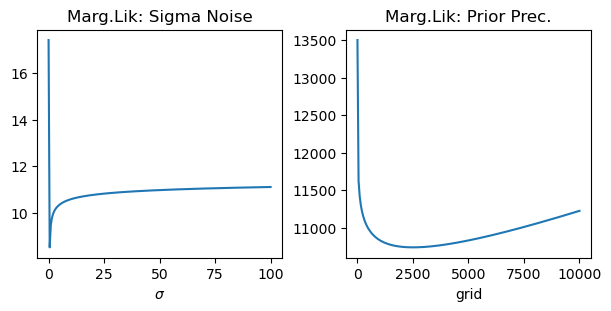

In [31]:
fig, axs = plt.subplots(1,2,figsize = (6,3), layout='constrained')

llp = torch.load(f"./models/nvs_lla2.pth")
llp.model.set_last_layer("output_layer")  # Re-register hooks

sn = torch.linspace(0.0001,100, 200)  # Spatial grid in X direction
log_marg_lh = []
for sn_val in sn:
    llp.sigma_noise = sn_val
    log_marg_lh.append(-llp.log_marginal_likelihood())
axs[0].plot(sn,np.log(log_marg_lh))
axs[0].set_xlabel("$\sigma$")
axs[0].set_title("Marg.Lik: Sigma Noise")

llp = torch.load(f"./models/nvs_lla2.pth")
llp.model.set_last_layer("output_layer")  # Re-register hooks

priorpre = torch.linspace(0.1,10000, 200)  # Spatial grid in X direction
log_marg_pp = []
for pp in priorpre:
    llp.prior_precision = [pp]
    log_marg_pp.append(-llp.log_marginal_likelihood())

axs[1].plot(priorpre,log_marg_pp)
axs[1].set_xlabel("grid")
axs[1].set_title("Marg.Lik: Prior Prec.")

In [29]:
llp = torch.load(f"./models/nvs_lla.pth")
llp.model.set_last_layer("output_layer")  # Re-register hooks
llp.prior_precision = 1.
# print(llp._H_factor, torch.linalg.norm(llp.H,ord=2),torch.linalg.norm(llp.prior_precision_diag,ord=2))
# print(torch.linalg.norm(llp.posterior_precision))
llp.optimize_marginal_likelihoodb(error_tolerance=1e-3, max_iter=5000)
print(llp.sigma_noise,llp.prior_precision)
# print(llp._H_factor, torch.linalg.norm(llp.H,ord=2),torch.linalg.norm(llp.prior_precision_diag,ord=2))
# print(torch.linalg.norm(llp.posterior_precision))

Iteration 100, Error: 0.01001, neg_marglik: 1229.59546
Iteration 200, Error: 0.01000, neg_marglik: -10441.39062
Iteration 300, Error: 0.00991, neg_marglik: -21935.70117
Iteration 400, Error: 0.00934, neg_marglik: -32229.28320
Iteration 500, Error: 0.00698, neg_marglik: -37602.02734
Iteration 600, Error: 0.00467, neg_marglik: -38283.35938
Iteration 700, Error: 0.00369, neg_marglik: -38477.81641
Iteration 800, Error: 0.00234, neg_marglik: -38577.64062
Iteration 900, Error: 0.00100, neg_marglik: -38604.68750
tensor(0.0080) tensor([2143.2124])


In [17]:
X = torch.linspace(0, 1, 128)*2*torch.pi  # Spatial grid in X direction
Y = torch.linspace(0, 1, 128)*2*torch.pi  # Spatial grid in Y direction
X, Y = torch.meshgrid(X, Y)  # Create meshgrid for X, Y

data_test = torch.hstack((X.reshape(-1,1),Y.reshape(-1,1),2*torch.ones_like(X.reshape(-1,1)))).float()

#th1 = theta[:,:,100].reshape(-1,1).T.repeat_interleave(data_test.shape[0], dim=0)
th1 = torch.tensor((-1000,1000)).reshape(-1,1).T.repeat_interleave(data_test.shape[0], dim=0)
#llp.sigma_noise = 0.021
dataset1 = torch.cat((data_test, th1), dim=1)  # Shape (16000, 103)

surg_mu, surg_sigma = llp(dataset1)

surg_mu = surg_mu[:,0].view(-1, 1).detach().numpy()

surg_sigma = surg_sigma[:, 0].view(-1, 1).detach().numpy()

pred_mu = griddata((X.reshape(-1), Y.reshape(-1)), surg_mu.flatten(),(X, Y), method='cubic')
pred_sigma = griddata((X.reshape(-1), Y.reshape(-1)), surg_sigma.flatten(),(X, Y), method='cubic')


fig, axs = plt.subplots(1,2,figsize = (10,5), layout='constrained', sharey=True, sharex=True)

pcm1 = axs[0].pcolormesh(X, Y, pred_mu, cmap='jet')
axs[0].set_title("NN Prediction")
plt.colorbar(pcm1)

pcm = axs[1].pcolormesh(X, Y, pred_sigma, cmap='jet')
axs[1].set_title("NN Uncertainty")
plt.colorbar(pcm)

_LinAlgError: linalg.cholesky: The factorization could not be completed because the input is not positive-definite (the leading minor of order 322 is not positive-definite).